# Test for Experiment 1: Weight fit
Here I will take one subtype and investigate how subtype weights relate to the covariate under investigation.

In [12]:
# Imports
import os
import glob
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from statsmodels import stats as stm
from statsmodels.sandbox import stats as sts
from statsmodels.sandbox.stats import multicomp as smi

In [3]:
%matplotlib inline

In [30]:
# Paths
scale = 7
name = 'n308_sample'
mtp_list= ['rmap_part', 'dual_regression', 'stability_maps']
mtp = mtp_list[2]

in_default = '{}_{}_scale_{:03d}'.format(mtp, name, scale)

prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
in_path = '/data1/subtypes/serial_preps/'

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'

## Build the subtypes

In [31]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [32]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [33]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [34]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

In [35]:
# Load the serialized netstack
netstack = np.load(netstack_path)
corr_mat = np.load(corrmat_path)

In [36]:
subtypes = 5

scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

In [37]:
def show_simple(net_id, sbt_id, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

## Investigate
I decided to look at network 2 at scale 7 and there specifically at subtypes 1, 2 and 3 because they have significant association both with ADOS and Diagnosis.


First, a visualization of network 2

In [ ]:
nid = 2
sbl = [1, 2, 3]

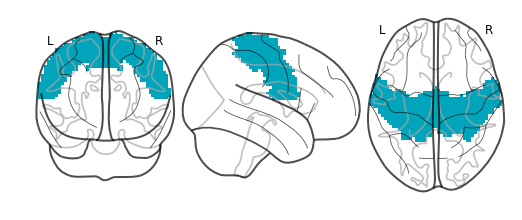

In [20]:
tmp = nlp.plot_glass_brain(nil.image.index_img(prior_img, nid), 
                           cmap=plt.cm.spectral, 
                           colorbar=False, vmin=1, vmax=scale)

### Show the subtypes for network 2

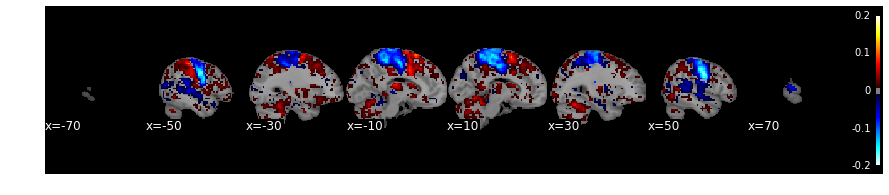

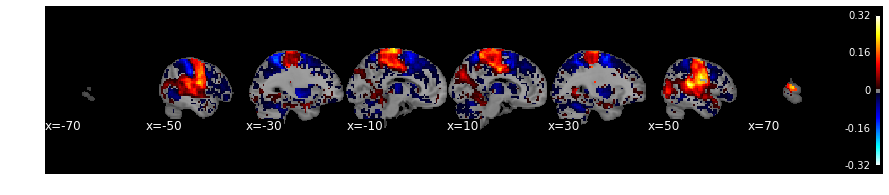

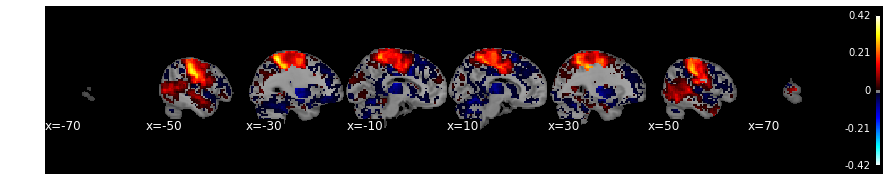

In [50]:
for sbid in sbl:
    tmp = show_simple(nid, sbid, sbt_store, view_mode='x', threshold=0.01)

## ADOS
I will look at the scatterplot of ADOS scores and subtype weights for these three subtypes (among the subjects with ADOS scores).

In [159]:
sub_ind = pd.notnull(pheno.replace(-9999, np.nan)['ADOS_TOTAL'])
ados_pheno = pheno[sub_ind]

In [170]:
w = weight_store[nid, 1, sub_ind.values]
# keep a copy for reference
w_keep = w
a = ados_pheno['ADOS_TOTAL'].values

fitW = np.concatenate((np.expand_dims(np.ones_like(w),1), 
                       np.expand_dims(w, 1)), axis=1)
robust = sm.RLM(a, fitW, M=sm.robust.norms.HuberT())
robres = robust.fit()

xnew = np.arange(-0.5, 0.5, 0.01)
rob_fit = robres.params[1] * xnew + robres.params[0]

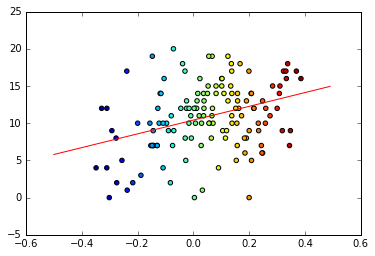

In [169]:
plt.scatter(w, a, c=w_keep)
plt.plot(xnew, rob_fit, 'r')

In [175]:
w = weight_store[5, 2, sub_ind.values]
a = ados_pheno['ADOS_TOTAL'].values

fitW = np.concatenate((np.expand_dims(np.ones_like(w),1), 
                       np.expand_dims(w, 1)), axis=1)
robust = sm.RLM(a, fitW, M=sm.robust.norms.HuberT())
robres = robust.fit()

xnew = np.arange(-0.5, 0.5, 0.01)
rob_fit = robres.params[1] * xnew + robres.params[0]

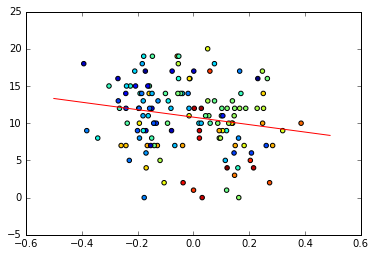

In [176]:
plt.scatter(w, a, c=-w_keep)
plt.plot(xnew, rob_fit, 'r')

In [ ]:
w = weight_store[nid, 2, sub_ind.values]
a = ados_pheno['ADOS_TOTAL'].values

fitW = np.concatenate((np.expand_dims(np.ones_like(w),1), 
                       np.expand_dims(w, 1)), axis=1)
robust = sm.RLM(a, fitW, M=sm.robust.norms.HuberT())
robres = robust.fit()

xnew = np.arange(-0.5, 0.5, 0.01)
rob_fit = robres.params[1] * xnew + robres.params[0]

In [143]:
rmse = np.sqrt(np.mean(np.square(robres.resid)))

In [144]:
rmse

4.4047752166922285

## Diagnosis

In [146]:
sub_ind = pd.notnull(pheno.replace(-9999, np.nan)['DX_GROUP'])
diag_pheno = pheno[sub_ind]

In [153]:
w = weight_store[nid, 3, sub_ind.values]
d = diag_pheno['DX_GROUP'].values
patients = (diag_pheno['DX_GROUP'] == 2).values
controls = ~patients

{u'bodies': [<matplotlib.collections.PolyCollection at 0x7f766575d410>,
 u'cbars': <matplotlib.collections.LineCollection at 0x7f76657806d0>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x7f766575d2d0>,
 u'cmins': <matplotlib.collections.LineCollection at 0x7f7665780250>}

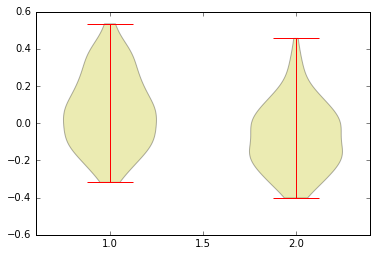

In [158]:
tmp = [w[patients], w[controls]]
plt.violinplot(tmp)